<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

### Do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it - one click for you, great pleasure for us ☺️ 

In [1]:
# s = '<iframe src="https://ghbtns.com/github-btn.html?user=AILab-MLTools&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
# HTML(s)

## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

LightAutoML это библиотека, способная автоматически строить модели машинного обучения для различный задач, например, бинарной классификации, регресии на табличных данных. В качестве входных данных могут являться и количественные и вещественные данные, категориальные, даты, тексты, изображения

In [2]:
#%%capture
#!pip install lightautoml

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch # используется внутри auto_ml

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [4]:
# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
#!pip install -U pandas

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

Создаём некоторые переменные/константы

In [2]:
N_THREADS = 4 # колчисество потоков
N_FOLDS = 5 # количество холдов кросс-валидации
RANDOM_STATE = 42 # фиксируем random_state для воспроизводимости нашего решения
TEST_SIZE = 0.2 # отделяем кусок нашей выборки для оценивания качества нашей модели, в данном случае 20%
TIMEOUT = 900 # equal to 10 minutes, время построения модели
TARGET_NAME = 'final_price' # имя целевой колонки

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [3]:
# фиксируем для воспроизводимости решения - гарантирует, что решение, запущенное несколько раз будет похоже по модели и score
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

**Примечание.** Для загрузки в локальный репозиторий воспользуйтесь командой: gdown 'https://drive.google.com/uc?id=1XWWqJeuVmHubRbj5LwDj8937q3m7D3IZ'

In [3]:
# загружаем тренировочный датасет
train_data_zip = pd.read_csv(r'train_data.csv')
train_data = train_data_zip.copy()
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


**Примечание.** Для загрузки в локальный репозиторий воспользуйтесь командой: gdown 'https://drive.google.com/uc?id=1HMVOlV73TJzxjhibsKiZPecY_r4Il2O1'

In [4]:
# тестовые данные для предсказания
test_data_zip = pd.read_csv(r'test_data.csv')
test_data = test_data_zip.copy()
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


**Примечание.** Для загрузки в локальный репозиторий воспользуйтесь командой: gdown 'https://drive.google.com/uc?id=1gZi--O7G82NWgVO3wvZTINXqZA4dmD8t'

In [5]:
# то, как должен выглядеть наш предикт когда мы его загружаем в кегл
submission_data = pd.read_csv(r'sample_submission.csv')
submission = submission_data.copy()
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### Step 0.5. Some user feature preparation

Be creative :)

In [7]:
country = {'ЮАР':['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH'], 'Кения':['BF', 'BG', 'BH', 'BI', 'BJ', 'BK'],
           'Мадагаскар':['CF', 'CG', 'CH', 'CI', 'CJ', 'CK'], 'Марокко':['DF', 'DG', 'DH', 'DI', 'DJ', 'DK'],
           'Мозамбик':['EF', 'EG', 'EH', 'EI', 'EJ', 'EK'], 'Кот-д’Ивуар':['AJ', 'AK', 'AL', 'AM', 'AN'],
           'Танзания':['BL', 'BM', 'BN', 'BL', 'BO', 'BP', 'BQ', 'BR'], 'Тунис':['CL', 'CM', 'CN', 'CL', 'CO', 'CP', 'CQ', 'CR'],
           'Замбия':['DL', 'DM', 'DN', 'DL', 'DO', 'DP', 'DQ', 'DR'], 'Гана':['FA', 'FB', 'FC', 'FD', 'FE'],
           'Ангола':['BA', 'BB', 'BC', 'BD', 'BE'], 'Бенин':['CA', 'CB', 'CC', 'CD', 'CE'],
           'Египет':['DA', 'DB', 'DC', 'DD', 'DE'], 'Эфиопия':['EA', 'EB', 'EC', 'ED', 'EE'],
           'Нигерия':['FF', 'FG', 'FH', 'FI', 'FJ', 'FK'], 'Япония':['JA', 'JB', 'JC', 'JD', 'JE', 'JF', 'JG', 'JH', 'JI', 'JK', 'JL', 'JM', 'JN', 'JO', 'JP', 'JQ', 'JR', 'JS', 'JT'],
           'Южная Корея':['KL', 'KM', 'KN', 'KL', 'KO', 'KP', 'KQ', 'KR'], 'Индонезия':['MF', 'MG', 'MH', 'MI', 'MJ', 'MK'],
           'Турция':['NL', 'NM', 'NN', 'NL', 'NO', 'NP', 'NQ', 'NR'], 'Малайзия':['PL', 'PM', 'PN', 'PL', 'PO', 'PP', 'PQ', 'PR'],
           'Вьетнам':['RL', 'RM', 'RN', 'RL', 'RO', 'RP', 'RQ', 'RR'], 'Шри Ланка':['KA', 'KB', 'KC', 'KD', 'KE'],
           'Китай':['LA', 'LB', 'LC,', 'LD', 'LE', 'LF', 'LG', 'LH', 'LI', 'LJ', 'LK', 'LL','LM', 'LN', 'LO', 'LP', 'LQ', 'LR', 'LS', 'LT', 'LU', 'LV', 'LW', 'LX', 'LY', 'LZ', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9'],
           'Таиланд':['ML', 'MM', 'MN', 'ML', 'MO', 'MP', 'MQ', 'MR'], 'Филиппины':['PA', 'PB', 'PC', 'PD', 'PE'],
           'ОАЭ':['RA', 'RB', 'RC', 'RD', 'RE'], 'Саудовская Аравия':['RR', 'RS', 'RT', 'RU', 'RV', 'RW', 'RX', 'RY', 'RZ', 'R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9'],
           'Израиль':['KF', 'KG', 'KH', 'KI', 'KJ', 'KK'], 'Индия':{'MA', 'MB', 'MC', 'MD', 'ME'},
           'Пакистан':['NF', 'NG', 'NH', 'NI', 'NJ', 'NK'], 'Сингапур':['PF', 'PG', 'PH', 'PI', 'PJ', 'PK'],
           'Тайвань':['RF', 'RG', 'RH', 'RI', 'RJ', 'RK'], 'Великобритания':['SA', 'SB', 'SC,', 'SD', 'SE', 'SF', 'SG', 'SH', 'SI', 'SJ', 'SK', 'SL', 'SN', 'SM'],
           'Чехия':['TJ', 'TK', 'TL', 'TN', 'TM', 'TO', 'TP'], 'Румыния':['UU', 'UV', 'UW', 'UX', 'UY', 'UZ'],
           'Сербия':['VX', 'VY', 'VZ', 'V1', 'V2'], 'Греция':['XE', 'XF', 'XG', 'XH', 'XI', 'XJ', 'XK'],
           'Бельгия':['YA', 'YB', 'YC', 'YD', 'YE'], 'Беларусь':['Y3', 'Y4', 'Y5'],
           'Венгрия':['TR', 'TS', 'TT', 'TU', 'TV'], 'Словакия':['U5', 'U6', 'U7'], 'Хорватия':['V3', 'V4', 'V5'], 'Нидерланды':['XL','XM', 'XN', 'XO', 'XP', 'XQ', 'XR'],
           'Финляндия':['YF', 'YG', 'YH', 'YI', 'YJ', 'YK'], 'Украина':['Y6', 'Y7', 'Y8', 'Y9', 'Y0'], 'Польша':['SU', 'SV', 'SW', 'SX', 'SY', 'SZ'],
           'Португалия':['TW', 'TX', 'TY', 'TZ', 'T1'], 'Австрия':['VA', 'VB', 'VC', 'VD', 'VE'], 'Эстония':['V6', 'V7', 'V8', 'V9', 'V0'],
           'СССР':['XS', 'XT', 'XU', 'XV', 'XW'], 'Мальта':['YL','YM', 'YN', 'YO', 'YP', 'YQ', 'YR'], 'Италия':['ZA', 'ZB', 'ZC', 'ZD', 'ZE', 'ZF', 'ZG', 'ZH', 'ZI', 'ZJ', 'ZK', 'ZL','ZM', 'ZN', 'ZO', 'ZP', 'ZQ', 'ZR'],
           'Латвия':['S1', 'S2', 'S3', 'S4'], 'Дания':['UH', 'UI', 'UJ', 'UK', 'UL','UM', 'UN'], 'Франция':['VF', 'VG', 'VH', 'VI', 'VJ', 'VK', 'VL','VM', 'VN', 'VO', 'VP', 'VQ', 'VR'],
           'Германия':['WA', 'WB', 'WC', 'WD', 'WE', 'WF', 'WG', 'WH', 'WI', 'WJ', 'WK', 'WL','WM', 'WN', 'WO', 'WP', 'WQ', 'WR', 'WS', 'WT', 'WU', 'WV', 'WW', 'WX', 'WY', 'WZ', 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'SN', 'SO', 'SP', 'SQ', 'SR', 'SS', 'ST'],
           'Люксембург':['XX', 'XY', 'XZ', 'X1', 'X2'], 'Швеция':['YS', 'YT', 'YU', 'YV', 'YW'], 'Словения':['ZX', 'ZY', 'ZZ', 'Z1', 'Z2'], 'Швейцария':['TA', 'TB', 'TC,', 'TD', 'TE', 'TF', 'TG', 'TH'],
           'Ирландия':['UN', 'UO', 'UP', 'UQ', 'UR', 'US', 'UT'], 'Испания':['VS', 'VT', 'VU', 'VV', 'VW'], 'Болгария':['XA', 'XB', 'XC,', 'XD', 'XE'],
           'Россия':['X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X0'], 'Норвегия':['YX', 'YY', 'YZ', 'Y1', 'Y2'], 'Литва':['Z3', 'Z4', 'Z5'],
           'США':['1A', '1B', '1C,', '1D', '1E', '1F', '1G', '1H', '1I', '1J', '1K', '1L','1M', '1N', '1O', '1P', '1Q', '1R', '1S', '1T', '1U', '1V', '1W', '1X', '1Y', '1Z', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
                  '5A', '5B', '5C,', '5D', '5E', '5F', '5G', '5H', '5I', '5J', '5K', '5L','5M', '5N', '5O', '5P', '5Q', '5R', '5S', '5T', '5U', '5V', '5W', '5X', '5Y', '5Z', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', 
                  '4A', '4B', '4C,', '4D', '4E', '4F', '4G', '4H', '4I', '4J', '4K', '4L','4M', '4N', '4O', '4P', '4Q', '4R', '4S', '4T', '4U', '4V', '4W', '4X', '4Y', '4Z', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49'],
           'Мексика':['3A', '3B', '3C,', '3D', '3E', '3F', '3G', '3H', '3I', '3J', '3K', '3L','3M', '3N', '3O', '3P', '3Q', '3R', '3S', '3T', '3U', '3V', '3W'], 'Каймановы острова':['38', '39', '30'],
           'Канада':['2A', '2B', '2C', '2D', '2E', '2F', '2G', '2H', '2I', '2J', '2K', '2L','2M', '2N', '2O', '2P', '2Q', '2R', '2S', '2T', '2U', '2V', '2W', '2X', '2Y', '2Z', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29'], 
           'Коста Рика':['3X', '3Y', '3Z', '31', '32', '33', '34', '35', '36', '37'], 'Австралия':['6A', '6B', '6C', '6D', '6E', '6F', '6G', '6H', '6I', '6J', '6K', '6L','6M', '6N', '6O', '6P', '6Q', '6R', '6S', '6T', '6U', '6V', '6W'],
           'Новая Зеландия':['7A', '7B', '7C', '7D', '7E'], 'Аргентина':['8A', '8B', '8C,', '8D', '8E'], 'Венесуэла':['8X', '8Y', '8Z', '81', '82'], 
           'Уругвай':['9S', '9T', '9U', '9V', '9W'], 'Чили':['8F', '8G', '8H', '8I', '8J', '8K'], 'Бразилия':['9A', '9B', '9C', '9D', '9E', '93', '94', '95', '96', '97', '98', '99'],
           'Тринидад и Тобаго':['9X', '9Y', '9Z', '91', '92'], 'Эквадор':['8L','8M', '8N', '8O', '8P', '8Q', '8R'],
           'Колумбия':['9F', '9G', '9H', '9I', '9J', '9K'], 'Перу':['8S', '8T', '8U', '8V', '8W'], 'Парагвай':['9L','9M', '9N', '9O', '9P', '9Q', '9R']} 

In [8]:
train_data['car_vin'] = train_data['car_vin'].apply(lambda x: x if x is not np.nan else '  -')
test_data['car_vin'] = test_data['car_vin'].apply(lambda x: x if x is not np.nan else '  -')

train_data = train_data[train_data['vehicle_year'] > 1980]
train_data = train_data[train_data['final_price'] < 90000]
train_data = train_data[train_data['current_mileage'] < 500000]

In [9]:
%%time

def create_expert_feats(data):
    code_vin = data[1:3]
    
    for key in country.keys():
        for value in country[key]:
            if value == code_vin:
                return key 

#create_expert_feats(tratrain['car_vin']
                    
train_data['car_vin'] = train_data['car_vin'].apply(create_expert_feats)
test_data['car_vin'] = test_data['car_vin'].apply(create_expert_feats)

CPU times: total: 922 ms
Wall time: 955 ms


In [11]:
def create_expert_feats_2(data):
    data['age_of_car'] = 2022 - data['vehicle_year']
    data = data.drop(['vehicle_year','doors_cnt','row_ID'], axis=1, inplace=True)
    return data

create_expert_feats_2(train_data)
create_expert_feats_2(test_data)

### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [12]:
# разбивка данных на тренировочную и hold out выборку

tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (27614, 13), te_data = (6904, 13)


,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,age_of_car
3609,HYUNDAI,Sonata,Sedan,199010,Automatic,Left wheel,Black,Black,None,1,For Sale,6097.0,11
8838,SUBARU,Forester,Jeep,174882,Automatic,Left wheel,Grey,NaN,Япония,1,For Sale,850.0,6
27035,HYUNDAI,Santa FE,Jeep,110000,Automatic,Left wheel,Grey,Black,None,1,For Sale,15056.0,7
19753,HYUNDAI,Sonata,Sedan,98,Automatic,Left wheel,White,Black,None,1,For Sale,19700.0,2
7120,VOLKSWAGEN,Jetta 1.4 TURBO,Sedan,97000,Tiptronic,Left wheel,Black,Black,None,0,For Sale,5400.0,6


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [13]:
# указываем какую именно задачу мы решаем, устанавливаем метрики(по умолчанию mse - среднеквадратичная ошибка)
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [15]:
# задаём роли переменных
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [16]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [18]:
%%time
# отправляем модель на обучение и получим предсказание на всю тренировочную выборку oof_pred, обязательно смотрим в логах Time limit - значит на какую то задачу не хватило времени

oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[15:52:43] Stdout logging level is INFO.
[15:52:43] Task: reg

[15:52:43] Start automl preset with listed constraints:
[15:52:43] - time: 900.00 seconds
[15:52:43] - CPU: 4 cores
[15:52:43] - memory: 16 GB

[15:52:43] Train data shape: (27614, 13)

[15:52:45] Layer 1 train process start. Time left 897.82 secs
[15:52:46] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:53:02] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2486.8143818920835
[15:53:02] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:53:02] Time left 880.64 secs

[15:53:05] Selector_LightGBM fitting and predicting completed
[15:53:06] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[15:53:23] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1723.2268281542415
[15:53:23] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:53:23] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 28.01 secs
[15:53:58] Hyperparameters optimization for Lvl_0_P

In [19]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [20]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[ 3845.3342 ],
       [ 3653.651  ],
       [ 3458.9363 ],
       ...,
       [11136.25   ],
       [ 4160.1226 ],
       [  630.42206]], dtype=float32)
Shape = (6904, 1)
CPU times: total: 25.5 s
Wall time: 7.69 s


In [21]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

TRAIN out-of-fold score: 1563.3009544763527
HOLDOUT score: 1554.3206517320311


In [22]:
oof_pred.data[:, 0]

array([ 4447.76    ,    62.732243, 14929.708   , ...,   384.25098 ,
        5017.388   ,  5954.1387  ], dtype=float32)

# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

CPU times: total: 62.5 ms
Wall time: 60 ms


<AxesSubplot:xlabel='Feature'>

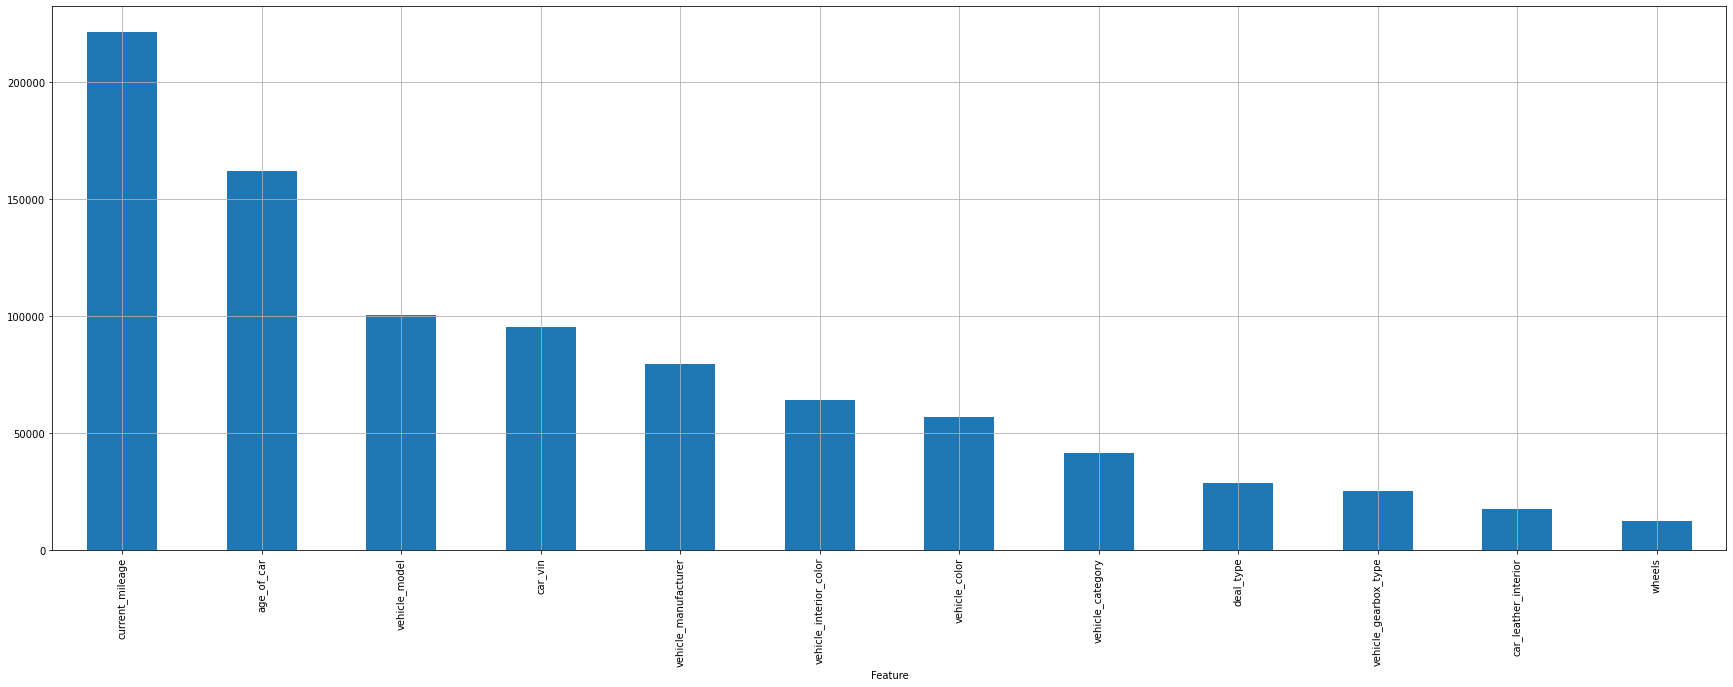

In [23]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [24]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

CPU times: total: 5min 40s
Wall time: 1min 35s


<AxesSubplot:xlabel='Feature'>

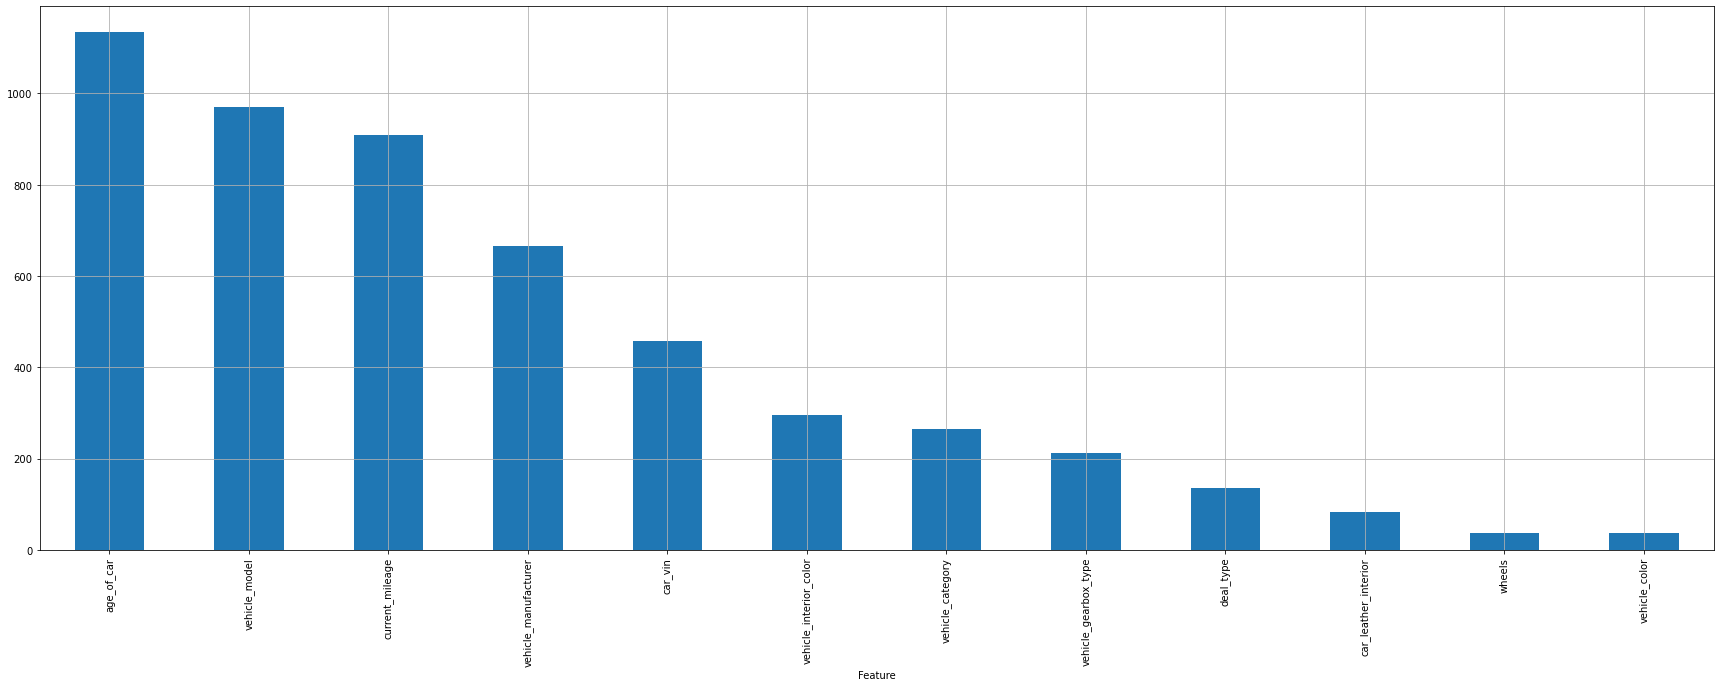

In [25]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

In [26]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2884.98 ],
       [ 6152.528],
       [ 4124.492],
       ...,
       [19310.576],
       [ 4879.01 ],
       [ 6475.168]], dtype=float32)
Shape = (10697, 1)


In [27]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('lightautoml_VIN_age_country.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

In [ ]:
# s = '<iframe src="https://ghbtns.com/github-btn.html?user=AILab-MLTools&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
# HTML(s)